In [398]:
# import libaries
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

- The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted.

In [399]:
# get the data from api

import io 
import requests
url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv'
src = requests.get(url).content
df = pd.read_csv(io.StringIO(src.decode('utf-8')))
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


## EDA (Explorative Data Analysis)

In [400]:
# size of data
df.shape

(346, 10)

In [401]:
type(df['due_date']) 
# time - Series format; need to change into pandas datetime

pandas.core.series.Series

In [402]:
# convert date to pandas datetime
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


**need to do about the data:**
- understanding the data (features, y-output: loan-staus)
- check patterns within missing values 
- the data includes categorical variables, need to one-hot encode them into numeric values 
- data visualization

In [403]:
# check missing values
df.isnull().sum()

# no missing values for each column and row

Unnamed: 0        0
Unnamed: 0.1      0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

In [404]:
# check loan-status
df['loan_status'].value_counts() 

# y - two cateogories; binary classification

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

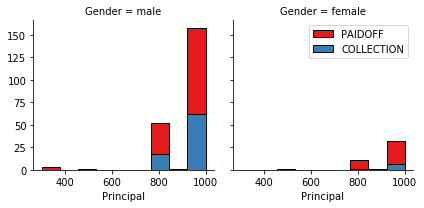

In [405]:
# visualiza gender difference vs principle

bins = np.linspace(df['Principal'].min(), df['Principal'].max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

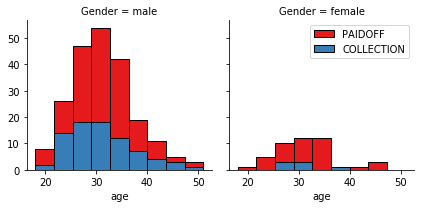

In [406]:
# gender, age, and loan status

bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

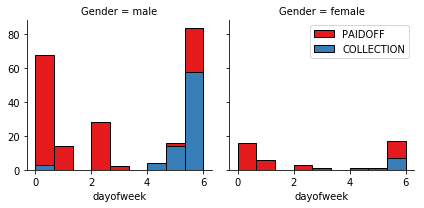

In [407]:
# day of week people pay off the loan 
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


In [408]:
# people who do payoff toward the end of a week (4, 5, 6, 7) as 1
df.head(2)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3


### gender and loat_status

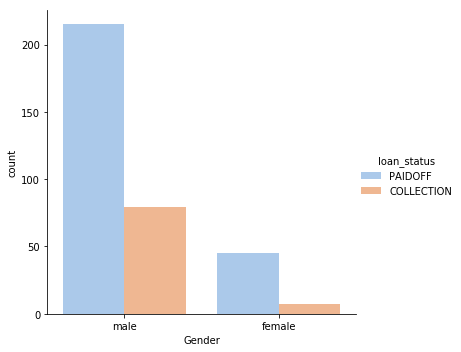

In [409]:
# gender and loan_status
sns.catplot(x="Gender", hue = 'loan_status', kind="count", palette="pastel", data=df);

In [410]:
# gender vs age overall nemeric values
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

- a higher percentage of female paid off their loans than male
- 86 % of female pay there loans; 73 % of males pay there loan
- gender may potentially infleunce the y

### education and loan_status

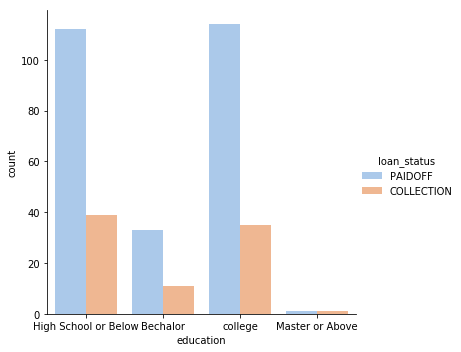

In [411]:
# eduaction and loan_status
sns.catplot(x="education", hue = 'loan_status', kind="count", palette="pastel", data=df);

In [412]:
# check if education tend to influence the tendency to pay off the loan
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [413]:
## overall paid-off and collection values
print(df.loan_status.value_counts())

len(df['loan_status'][df['loan_status'] == 'COLLECTION'])/ len(df)

# data set is slightly imbalanced 

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64


0.24855491329479767

## Feature selection

In [414]:
df['Gender'][df.Gender == 'male'] = 1
df['Gender'][df.Gender == 'female'] = 0
df.head(2)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,1,3
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,0,3


In [415]:
# change weekend into 2 catrgories
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,1,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,0,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,1,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,0,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,1,4,1


In [416]:
### select a subdataset with selected features and one-hot encode
df_sub = df[['Principal','terms','age','Gender','weekend']]

df_sub = pd.concat([df_sub, pd.get_dummies(df['education'])], axis=1)
df_sub.drop(['Master or Above'], axis = 1,inplace=True)
df_sub.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,1,0,0,1,0
1,1000,30,33,0,0,1,0,0
2,1000,15,27,1,0,0,0,1
3,1000,30,28,0,1,0,0,1
4,1000,30,29,1,1,0,0,1


## Model fit 

In [417]:
# define X, y
X = df_sub
y = df.loan_status.values

# scale the data using standard scaler
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# Classification 

## KNN

In [418]:
# modeling

from sklearn.neighbors import KNeighborsClassifier
k = 3
#Train Model and Predict  
knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
knn_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [419]:
y_pred = knn_model.predict(X_test)
y_pred[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [420]:
from sklearn import metrics
K = 15
mean_acc = np.zeros((K-1))
std_acc = np.zeros((K-1))
ConfustionMx = [];

for n in range(1, K): 
    knn_model = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    
    mean_acc[n-1] = np.mean(y_test == y_pred);
    std_acc[n-1] = np.std(y_test == y_pred)/np.sqrt(y_pred.shape[0])

mean_acc

array([0.67, 0.66, 0.71, 0.69, 0.76, 0.71, 0.79, 0.76, 0.76, 0.67, 0.7 ,
       0.73, 0.7 , 0.7 ])

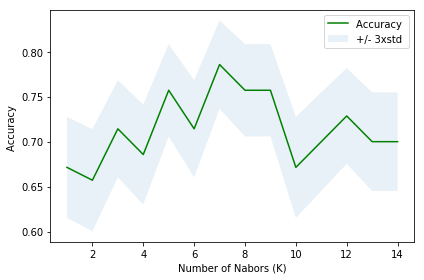

In [421]:
# plot the graph
plt.plot(range(1, K), mean_acc,'g')
plt.fill_between(range(1,K),mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [422]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 7


**Choose the best k; k = 7**

In [423]:
# the best k = 7; then build and evaluate the model
k = 7 
knn_model = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
y_pred = neigh.predict(X_test)
y_pred_prob = knn_model.predict_proba(X_test)


## Decision Tree

In [424]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train, y_train)  
y_pred = dt.predict(X_test)
y_pred_prob = dt.predict_proba(X_test)

In [425]:
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat))

DecisionTrees's Accuracy:  0.7142857142857143


- classification rate of 70%, good accuracy. 

#### Visualize the tree

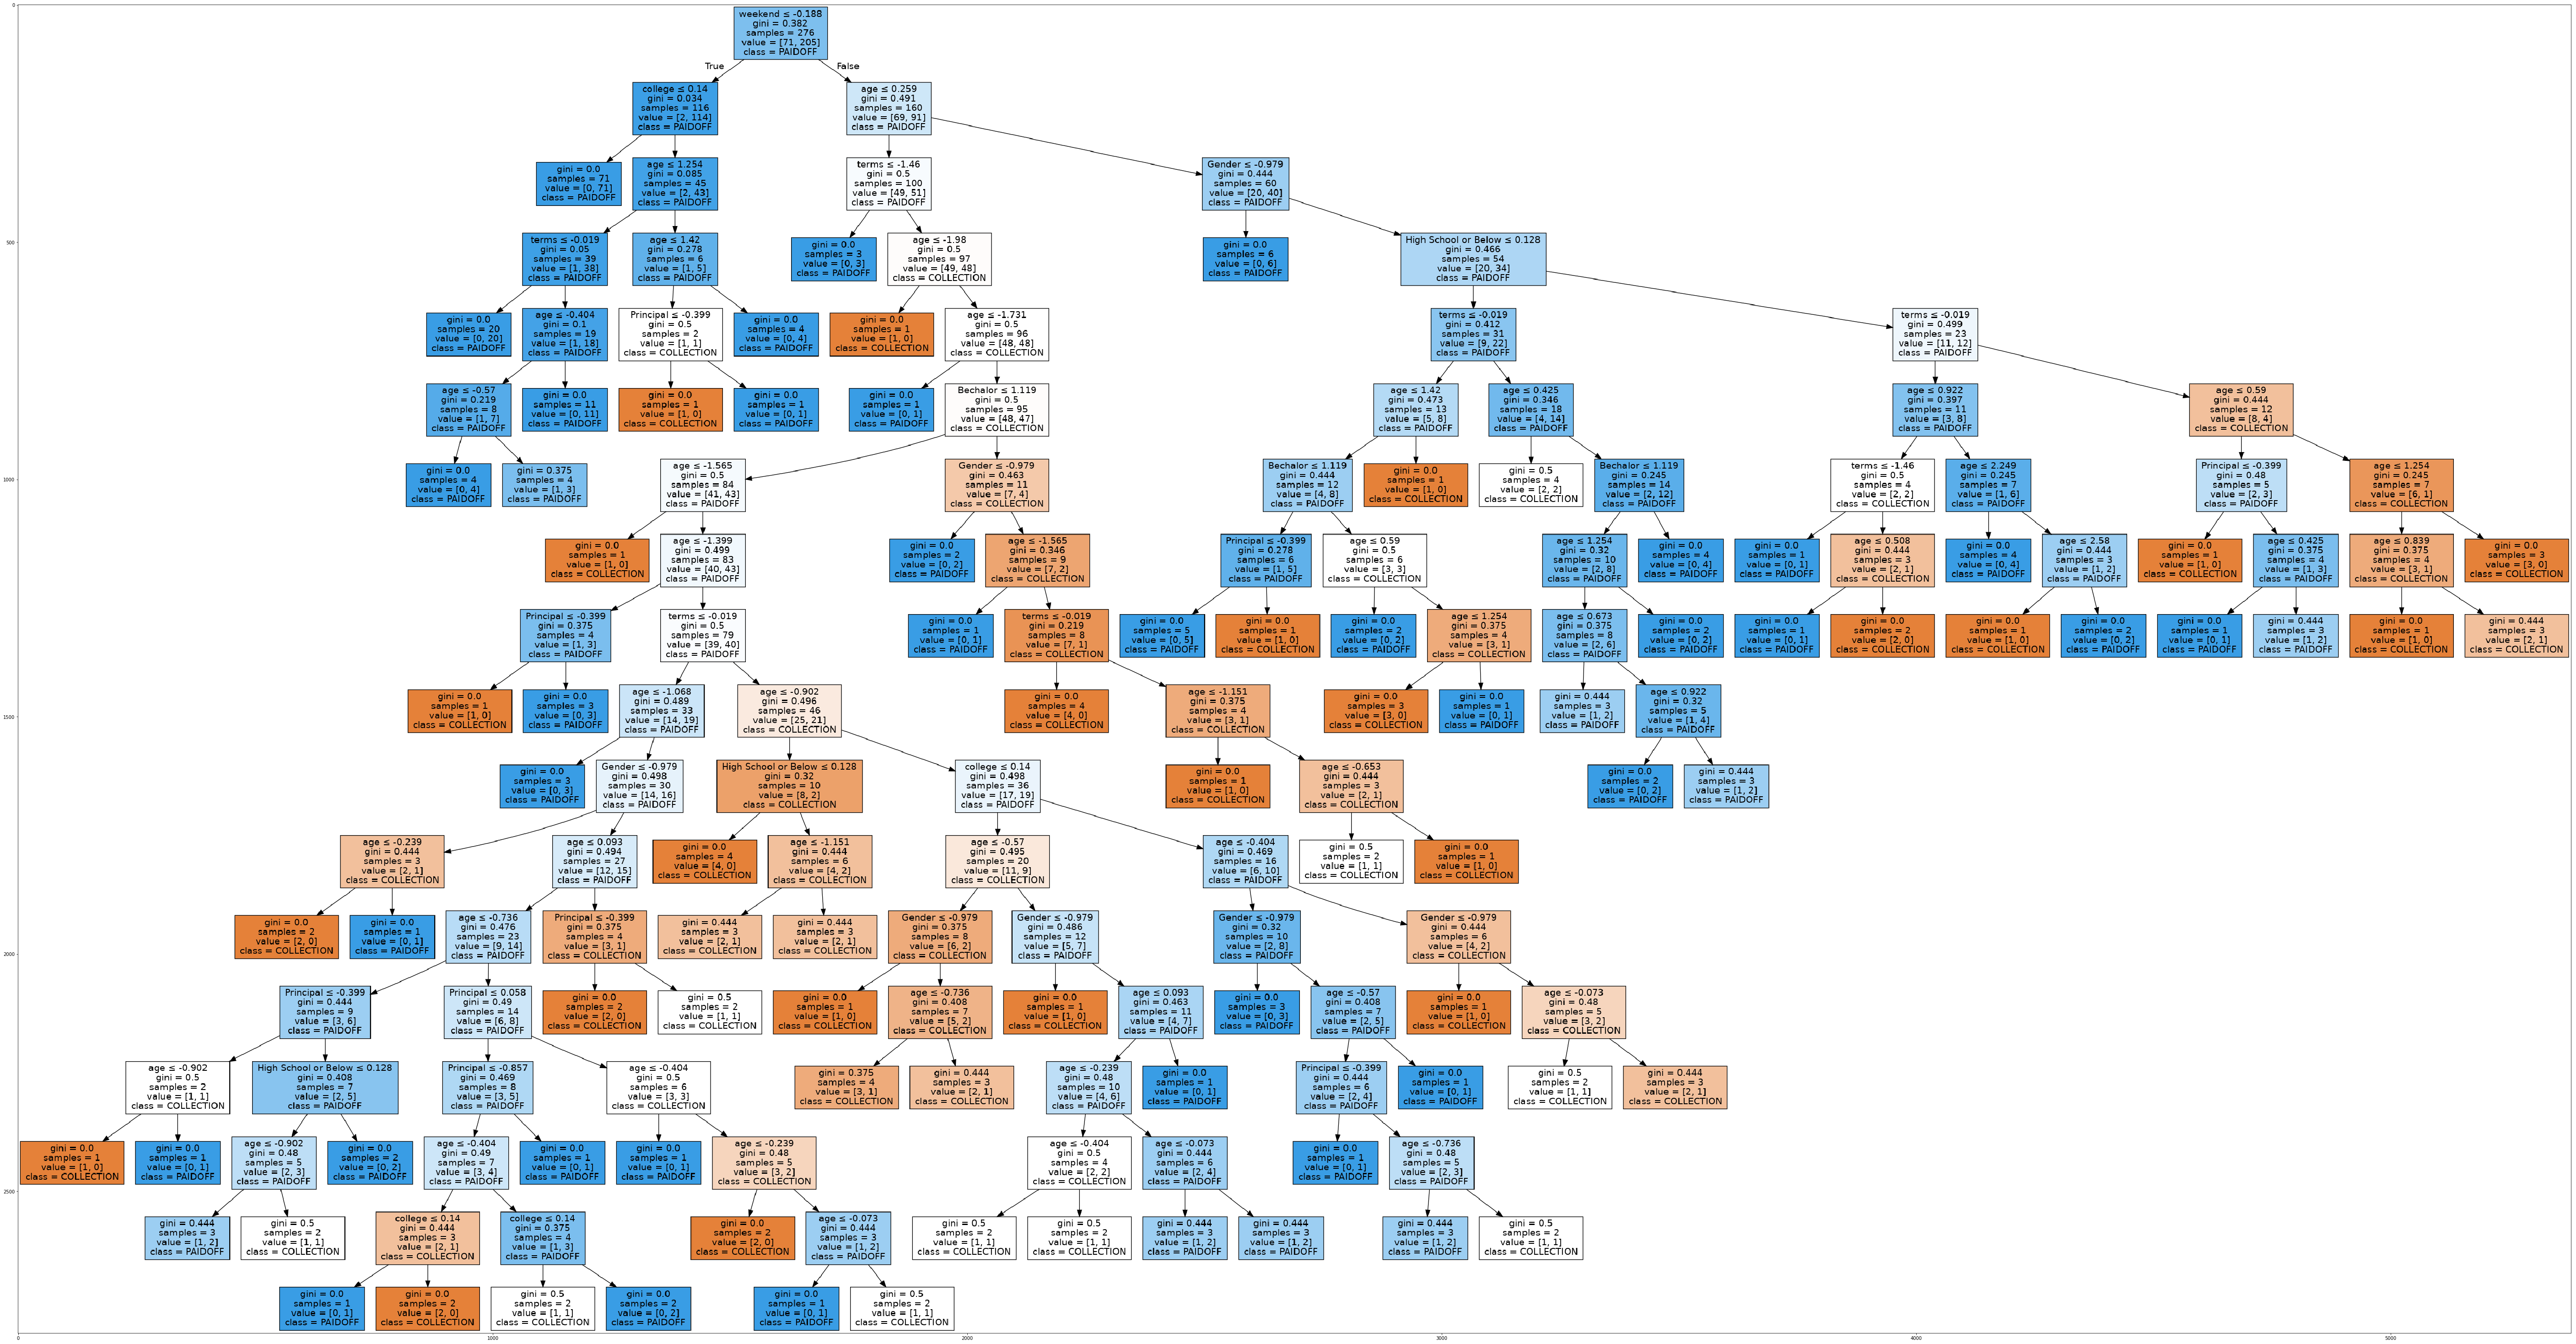

In [426]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree


dot_data = StringIO()

filename = "tree.png"
featureNames = df_sub.columns
targetNames = df.loan_status.unique().tolist()

out = tree.export_graphviz(dt,
                         feature_names = featureNames, 
                         out_file = dot_data, 
                         class_names = np.unique(y_train), 
                         filled = True,  
                         special_characters = True,
                         rotate = False) 

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)

plt.figure(figsize=(100, 200))
plt.imshow(img, interpolation='nearest')

#### optimize the tree model

In [427]:
# Create Decision Tree classifer object and train the Decision Tree Classifer
dt1 = DecisionTreeClassifier(criterion="entropy", max_depth=4).fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dt1.predict(X_test)
yhat_prob1 = dt1.predict_proba(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, yhat1))

Accuracy: 0.6142857142857143


- classification rate increased to 61.42%, which is better accuracy than earlier

In [428]:
# print results
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, yhat1)
print(cm)

[[ 7  8]
 [19 36]]


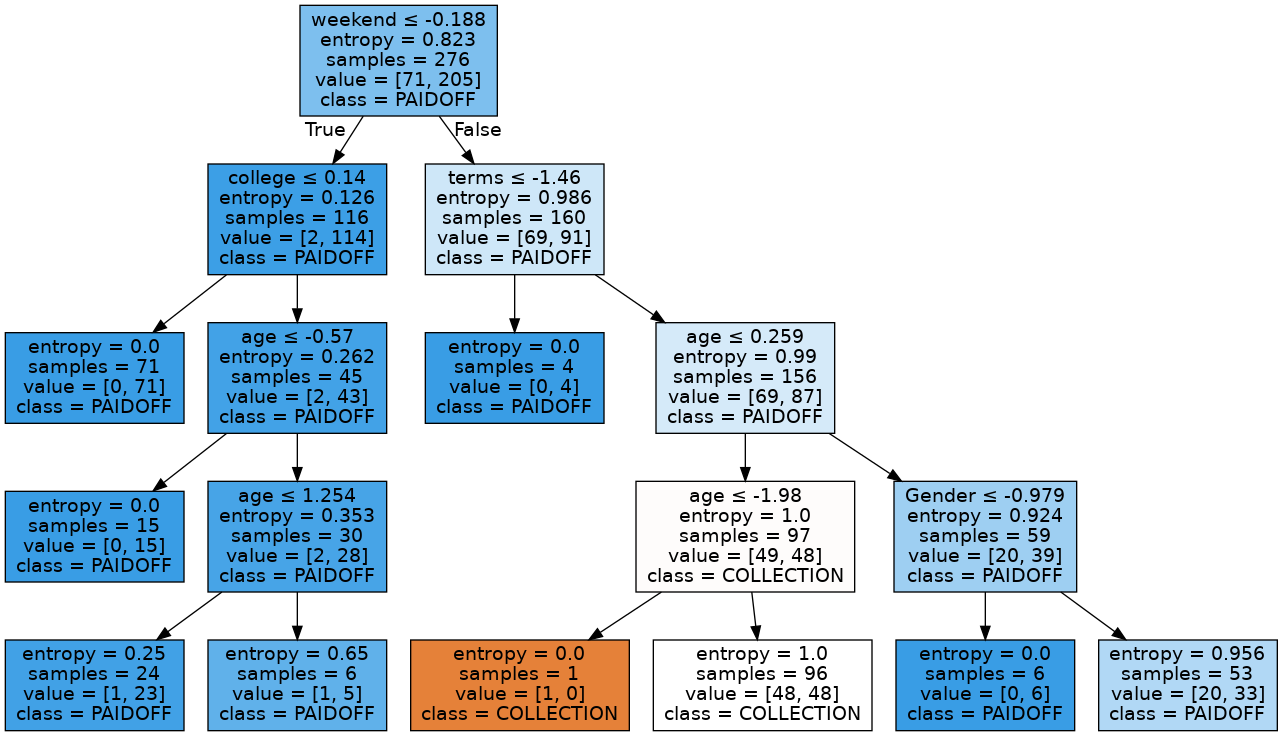

In [429]:
# visualize this tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

featureNames = df_sub.columns
targetNames = df.loan_status.unique().tolist()

out = export_graphviz(dt1,
                         feature_names = featureNames, 
                         out_file = dot_data, 
                         class_names = np.unique(y_train), 
                         filled = True,  
                         special_characters = True,
                         rotate = False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

filename = "tree_optimized.png"
graph.write_png(filename)
Image(graph.create_png())
# img = mpimg.imread(filename)

# plt.figure(figsize=(100, 200))
# plt.imshow(img, interpolation='nearest')


## Support Vector Machine SVM

In [430]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools

clf = svm.SVC(kernel='rbf').fit(X_train, y_train)  
y_pred = clf.predict(X_test)


In [431]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70



In [432]:
# print results
cm2 = confusion_matrix(y_test, y_pred)
print(cm2)

[[ 4 11]
 [ 7 48]]


In [433]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, # Normalization can be applied by setting `normalize=True`.
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.22      0.13      0.17        15
     PAIDOFF       0.79      0.87      0.83        55

   micro avg       0.71      0.71      0.71        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.67      0.71      0.69        70

Confusion matrix, without normalization
[[ 2 13]
 [ 7 48]]


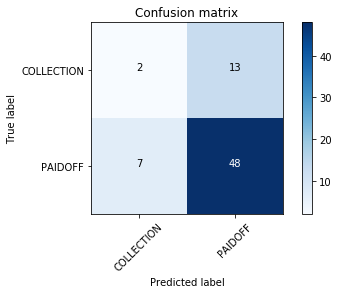

In [434]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['COLLECTION','PAIDOFF'])
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION','PAIDOFF'], normalize= False,  title='Confusion matrix')

### Logistic Regression

In [435]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train,y_train)
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)

In [436]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
print(cnf_matrix)

[[48  7]
 [13  2]]


In [437]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  COLLECTION       0.22      0.13      0.17        15
     PAIDOFF       0.79      0.87      0.83        55

   micro avg       0.71      0.71      0.71        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.67      0.71      0.69        70



# model evaluation 

In [438]:
# # Test Data Set
url2 = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'
src2 = requests.get(url).content
df_test = pd.read_csv(io.StringIO(src2.decode('utf-8')))
print(df_test.head())
print(df_test.shape)
print(df_test.isnull().sum())

   Unnamed: 0  Unnamed: 0.1 loan_status  Principal  terms effective_date  \
0           0             0     PAIDOFF       1000     30       9/8/2016   
1           2             2     PAIDOFF       1000     30       9/8/2016   
2           3             3     PAIDOFF       1000     15       9/8/2016   
3           4             4     PAIDOFF       1000     30       9/9/2016   
4           6             6     PAIDOFF       1000     30       9/9/2016   

    due_date  age             education  Gender  
0  10/7/2016   45  High School or Below    male  
1  10/7/2016   33              Bechalor  female  
2  9/22/2016   27               college    male  
3  10/8/2016   28               college  female  
4  10/8/2016   29               college    male  
(346, 10)
Unnamed: 0        0
Unnamed: 0.1      0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64


In [439]:
### select a subdataset with selected features and one-hot encode
df_test['effective_date'] = pd.to_datetime(df_test['effective_date'])
df_test['dayofweek'] = df_test['effective_date'].dt.dayofweek
df_test['weekend'] = df_test['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# get a subset of data
df_sub_test = df_test[['Principal','terms','age','Gender','weekend']]
df_sub_test['Gender'][df_sub_test.Gender == 'male'] = 1
df_sub_test['Gender'][df_sub_test.Gender == 'female'] = 0
df_sub_test = pd.concat([df_sub_test, pd.get_dummies(df_test['education'])], axis=1)
df_sub_test.drop(['Master or Above'], axis = 1,inplace=True)

test_X = preprocessing.StandardScaler().fit(df_sub_test).transform(df_sub_test)
test_X[0:5]

array([[ 0.52,  0.92,  2.33,  0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34, -2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65,  0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49, -2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32,  0.42,  0.83, -0.38, -0.88,  1.15]])

In [440]:
test_y = df_test.loan_status.values
test_y[0:20]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

In [441]:
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

In [442]:
# KNN
knn_pred = knn_model.predict(test_X)

print("Test set Accuracy: ", metrics.accuracy_score(test_y, knn_pred))
print('Weighted F1 score:', f1_score(test_y, knn_pred, average='weighted'))
print("jaccard_similarity_score: ", jaccard_similarity_score(test_y, knn_pred))

Test set Accuracy:  0.8034682080924855
Weighted F1 score: 0.795270290446172
jaccard_similarity_score:  0.8034682080924855


In [443]:
## Decision Tree
dt_pred = dt1.predict(test_X)

print("Test set Accuracy: ", metrics.accuracy_score(test_y, dt_pred))
print('Weighted F1 score:', f1_score(test_y, dt_pred, average='weighted'))
print("jaccard_similarity_score: ", jaccard_similarity_score(test_y, dt_pred))

Test set Accuracy:  0.7196531791907514
Weighted F1 score: 0.7337306459275745
jaccard_similarity_score:  0.7196531791907514


In [444]:
## SVM
svm_pred = clf.predict(test_X)

print("Test set Accuracy: ", metrics.accuracy_score(test_y, svm_pred))
print('Weighted F1 score:', f1_score(test_y, svm_pred, average='weighted'))
print("jaccard_similarity_score: ", jaccard_similarity_score(test_y, svm_pred))

Test set Accuracy:  0.7745664739884393
Weighted F1 score: 0.7598610906869676
jaccard_similarity_score:  0.7745664739884393


In [447]:
## Logistic Regression
logreg_pred = logreg.predict(test_X)
logreg_pred_prob = logreg.predict_proba(test_X)
print("Test set Accuracy: ", metrics.accuracy_score(test_y, logreg_pred))
print('Weighted F1 score:', f1_score(test_y, logreg_pred, average='weighted'))
print("jaccard_similarity_score: ", jaccard_similarity_score(test_y, logreg_pred))
from sklearn.metrics import log_loss
print('The log loss is:', log_loss(test_y, logreg_pred_prob))

Test set Accuracy:  0.7543352601156069
Weighted F1 score: 0.7325035789240646
jaccard_similarity_score:  0.7543352601156069
The log loss is: 0.4377053935779766


### Summary


In [452]:
list_acc = [metrics.accuracy_score(test_y, knn_pred),
           metrics.accuracy_score(test_y, dt_pred),
           metrics.accuracy_score(test_y, svm_pred),
           metrics.accuracy_score(test_y, logreg_pred)]
    
list_jc = [jaccard_similarity_score(test_y, knn_pred), 
           jaccard_similarity_score(test_y, dt_pred),
           jaccard_similarity_score(test_y, svm_pred),
            jaccard_similarity_score(test_y, logreg_pred)]

list_fs = [f1_score(test_y, knn_pred, average='weighted'),
          f1_score(test_y, dt_pred, average='weighted'),
          f1_score(test_y, svm_pred, average='weighted'),
          f1_score(test_y, logreg_pred, average='weighted')]

list_ll = ['NA', 'NA', 'NA', log_loss(test_y, logreg_pred_prob)]

df = pd.DataFrame(list_acc, index=['KNN','Decision Tree','SVM','Logistic Regression'])
df.columns = ['KNN']

df.insert(loc = 1, column='Jaccard', value = list_jc)
df.insert(loc = 2, column='F1-score', value = list_fs)
df.insert(loc = 3, column='LogLoss', value = list_ll)
df.columns.name = 'Algorithm'
df

Algorithm,KNN,Jaccard,F1-score,LogLoss
KNN,0.803468,0.803468,0.795270,NA
Decision Tree,0.719653,0.719653,0.733731,NA
SVM,0.774566,0.774566,0.759861,NA
Logistic Regression,0.754335,0.754335,0.732504,0.437705


- it seem that KNN perfom the best